# LINCS Publications & Citations Report

*Created by Brian M. Schilder, Moshe Silverstein, and Alexandra Keenan on 09/22/2018.*

In [1]:
import sys
print (sys.version)

3.6.3 (v3.6.3:2c5fed86e0, Oct  3 2017, 00:32:08) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


## Summary
- Plots:
	- Publications over time
	- Publications per LINCS center
	- Citations over time
	- Citations per center


- Repeat these plots for each of the following groupings:
	- Aggregated across internal LINCS centers

	- Divided amongst internal LINCS centers (label by center, not PI)
		1. Data Coordination and Integration Center (Mount Sinai, Avi Ma’ayan)
		2. Drug Toxicity Signature Generation Center (Mount Sinai, Ravi Iyengar)
		3. LINCS Proteomic Characterization Center for Signaling and Epigenetics (Broad Institute, Jacob Jaffe)
		4. Microenvironment Perturbagen (MEP) LINCS Center (Oregon Health & Science University, Joe Gray)
		5.	HMS LINCS Center (Peter Sorger)
		6.	LINCS Center for Transcriptomics (Broad Institute, Todd Golub)
		7.	NeuroLINCS Center  (UC-Irvine, Leslie Thompson)
	- Across all groups external to LINCS (E.g. papers that used L1000, Canvas Browser). 


### Import Data

In [35]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
sn.set_style('whitegrid')
sn.set(font_scale=1.5) 
# Publications (internal and external to the LINCS centers)
# Collected by Moshe Silverstein
pubs = pd.read_table('publications.tsv')
pubs.rename(columns={'id':'publication_id'}, inplace=True) 
pubs.columns
# Additional publications (internal and external to the LINCS centers)
#  collected by Alexandra Keenan
pubs2 = pd.read_csv('additional_pubs.csv')

internal = pubs.loc[pubs['center_pub']==1,:]
external = pubs.loc[pubs['center_pub']==0,:] 

authors = pd.read_table('authors.tsv')
authors.rename(columns={'id':'author_id'}, inplace=True)

authors_pubs = pd.read_table('authors_publications.tsv')

authorKey = authors.merge(authors_pubs, on='author_id')



# Assign centers
PIs = {"Ma'ayan":{'center':'DCIC','isAuthor':[]},
       'Iyengar':{'center':'Drug Toxicity','isAuthor':[]},
       'Jaffe':{'center':'Proteomics','isAuthor':[]},
       'Gray':{'center':'Microenvironment','isAuthor':[]},
       'Sorger':{'center':'HMS','isAuthor':[]},
       'Golub':{'center':'Transcriptomics','isAuthor':[]},
       'Thompson':{'center':'NeuroLINCS','isAuthor':[]}
       }
# Check whether author in authors list for each pub
for i,row in authorKey.iterrows(): 
    for pi in PIs:
        if row.loc['name'].__contains__(pi):
            PIs[pi]['isAuthor'] += [1] 
        else:
            PIs[pi]['isAuthor'] += [0] 
for pi in PIs:
    authorKey[PIs[pi]['center']] = PIs[pi]['isAuthor']
    

authorKey['publication_id'].unique()
internal['publication_id'] = internal.loc[:,'publication_id'].astype(int)

internalKeys = internal.merge(authorKey, on='publication_id') 


/Users/schilder/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Get Citations from PubMed API
Documentation: 
- https://www.ncbi.nlm.nih.gov/pmc/tools/cites-citedby/
- https://www.ncbi.nlm.nih.gov/books/NBK25497/

Note: To use the API you must first register your tool and email with NCBI by emailing eutilities@ncbi.nlm.nih.gov

In [36]:
pubmed_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'+\
             'elink.fcgi?dbfrom=pubmed&linkname=pubmed_pmc_refs&id='

tool = 'MaayanLab'
email = 'brian_schilder@alumni.brown.edu'
# You can register an API in your NCBI account settings to submit up to 10 requests/second
# ,instead of the default 3 requests/second
APIkey = 'ff789492667dabdb0c98afa776eb2090cc08'
PMClist = pubs['pmc_id'].str.strip('PMC').str.strip(' ').astype(str)
PMClist = PMClist[PMClist!='nan']
urls = pubmed_url+PMClist +'&tool='+tool+'&email='+email+'&api_key='+APIkey
url=urls[0]

from requests import get
import xmltodict   
import time
citations={} 
def getCitations(url): 
    PMC = url.split('refs&id=')[1] 
    response = get(str(url))
    citDict = xmltodict.parse(response.content)
    if 'LinkSetDb' in citDict:
        citationInfo = citDict['eLinkResult']['LinkSet']['LinkSetDb']['Link']
        allCitations = [x['Id'] for x in citationInfo ] 
        citations[PMC] = len(set(allCitations)) # Get unique citations
        status = 'found'
        # Can only submit up to 10 requests/second
        time.sleep(.11)

    else:
        citations[PMC] = 0 
        status = 'none found'
    print("Extracting Citations for PMC : "+PMC+"........ "+status)
    return citations
# res = map(getCitations, urls)
# results = list(res)


# # Using BioPython
# from Bio import Entrez
# Entrez.email = "brian.schilder@alumni.brown.edu"     # Always tell NCBI who you are
# id_list = ["19304878", "18606172", "16403221", "16377612", "14871861", "14630660"]
# print(Entrez.epost("pubmed", id=",".join(id_list)).read())

## Internal LINCS Publications

### Aggregated Across Centers

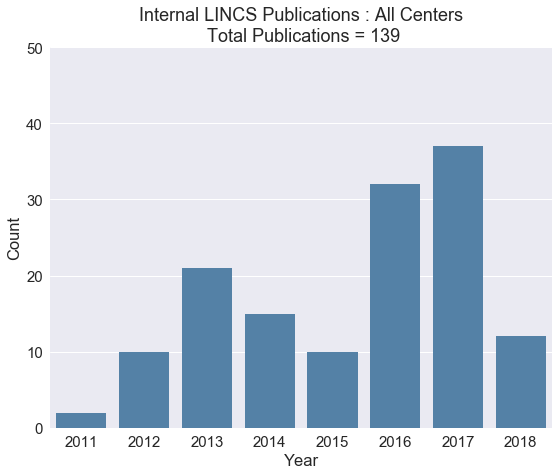

In [44]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100
years = internal.dropna(subset=['year_published'])['year_published'].astype(int)
years = years[years>1]
sn.countplot( years, color='steelblue')
plt.title('Internal LINCS Publications : All Centers\n Total Publications = '+
          str(len(years)))
plt.xlabel('Year')
plt.ylabel('Count')
plt.ylim(0,50);

### Separated By Center

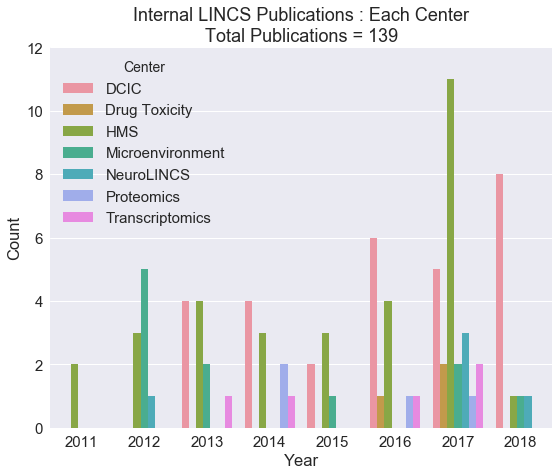

In [47]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100

internalByCenter = {}
for pi in PIs:
    center = PIs[pi]['center']
    internalByCenter[center] = internalKeys.groupby('year_published')[center].sum()
    
internalByCenter = pd.DataFrame(internalByCenter).stack().reset_index()
internalByCenter.columns = ['year_published', 'Center', 'Count']
internalByCenter['year_published'] = internalByCenter['year_published'].astype(int)
sn.barplot(data=internalByCenter, x='year_published',y='Count',hue='Center')
plt.title('Internal LINCS Publications : Each Center\nTotal Publications = '
          +str(len(years)))
plt.xlabel('Year')
plt.ylabel('Count')
plt.ylim(0,12);


## Internal LINCS CITATIONS

### Aggregated Across Centers

### Separated By Center

## External LINCS Publications

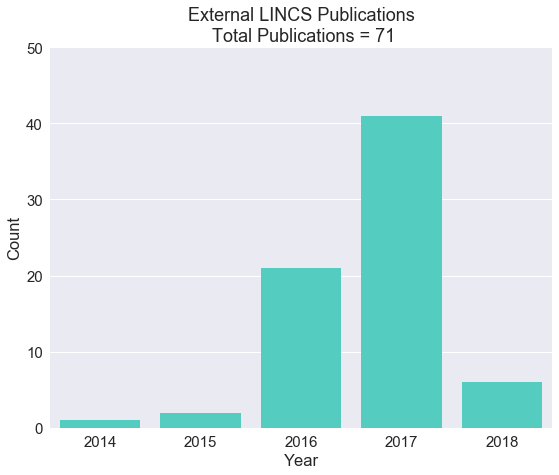

In [48]:
plt.figure(figsize=(9,7)) # Default 8,6 #, dpi=100

years = external.dropna(subset=['year_published'])['year_published'].astype(int)
years = years[years>1]
sn.countplot( years, color='turquoise')
plt.title('External LINCS Publications\n Total Publications = '+str(len(years)))
plt.xlabel('Year')
plt.ylabel('Count')
plt.ylim(0,50);